In [6]:
from pathlib import Path
from tqdm.notebook import tqdm
import librosa
import librosa.display
import numpy as np
import soundfile
import pandas as pd
import joblib


import random
import os

## Parameters
Let's introduce a few convenience variables.

In [7]:
SR = 32_000
DURATION = 5
SEED = 42

In [8]:
PATH_DATASET = Path.home() / "datasets/kaggle/birdclef-2021"
PATH_DATASET.exists()

True

In [9]:
L_birds = [path.name for path
           in (PATH_DATASET / "train_short_audio").iterdir()]
L_birds[:10]

['cubthr',
 'grekis',
 'cotfly1',
 'carwre',
 'norcar',
 'wesblu',
 'bknsti',
 'linspa',
 'creoro1',
 'yebela1']

In [10]:
sorted(L_birds) == L_birds

False

In [11]:
D_label_index = {label: i for i, label in enumerate(L_birds)}
D_label_index

{'cubthr': 0,
 'grekis': 1,
 'cotfly1': 2,
 'carwre': 3,
 'norcar': 4,
 'wesblu': 5,
 'bknsti': 6,
 'linspa': 7,
 'creoro1': 8,
 'yebela1': 9,
 'grasal1': 10,
 'bkbwar': 11,
 'fiespa': 12,
 'scptyr1': 13,
 'willet1': 14,
 'banwre1': 15,
 'tuftit': 16,
 'easblu': 17,
 'amerob': 18,
 'rcatan1': 19,
 'rtlhum': 20,
 'rufhum': 21,
 'sander': 22,
 'buhvir': 23,
 'rehbar1': 24,
 'chispa': 25,
 'higmot1': 26,
 'monoro1': 27,
 'thbeup1': 28,
 'acowoo': 29,
 'bkcchi': 30,
 'yeteup1': 31,
 'sltred': 32,
 'houspa': 33,
 'cregua1': 34,
 'yetvir': 35,
 'mouwar': 36,
 'cocwoo1': 37,
 'ducfly': 38,
 'casfin': 39,
 'shicow': 40,
 'blbthr1': 41,
 'subfly': 42,
 'wrenti': 43,
 'oaktit': 44,
 'pirfly1': 45,
 'phivir': 46,
 'orcpar': 47,
 'lesvio1': 48,
 'chbchi': 49,
 'calqua': 50,
 'buggna': 51,
 'wegspa1': 52,
 'categr': 53,
 'brebla': 54,
 'squcuc1': 55,
 'dusfly': 56,
 'pinsis': 57,
 'stvhum2': 58,
 'thswar1': 59,
 'gbbgul': 60,
 'brratt1': 61,
 'putfru1': 62,
 'clcrob': 63,
 'runwre1': 64,
 'bkbmag1'

In [12]:
D_index_label = {v: k for k, v in D_label_index.items()}
D_index_label

{0: 'cubthr',
 1: 'grekis',
 2: 'cotfly1',
 3: 'carwre',
 4: 'norcar',
 5: 'wesblu',
 6: 'bknsti',
 7: 'linspa',
 8: 'creoro1',
 9: 'yebela1',
 10: 'grasal1',
 11: 'bkbwar',
 12: 'fiespa',
 13: 'scptyr1',
 14: 'willet1',
 15: 'banwre1',
 16: 'tuftit',
 17: 'easblu',
 18: 'amerob',
 19: 'rcatan1',
 20: 'rtlhum',
 21: 'rufhum',
 22: 'sander',
 23: 'buhvir',
 24: 'rehbar1',
 25: 'chispa',
 26: 'higmot1',
 27: 'monoro1',
 28: 'thbeup1',
 29: 'acowoo',
 30: 'bkcchi',
 31: 'yeteup1',
 32: 'sltred',
 33: 'houspa',
 34: 'cregua1',
 35: 'yetvir',
 36: 'mouwar',
 37: 'cocwoo1',
 38: 'ducfly',
 39: 'casfin',
 40: 'shicow',
 41: 'blbthr1',
 42: 'subfly',
 43: 'wrenti',
 44: 'oaktit',
 45: 'pirfly1',
 46: 'phivir',
 47: 'orcpar',
 48: 'lesvio1',
 49: 'chbchi',
 50: 'calqua',
 51: 'buggna',
 52: 'wegspa1',
 53: 'categr',
 54: 'brebla',
 55: 'squcuc1',
 56: 'dusfly',
 57: 'pinsis',
 58: 'stvhum2',
 59: 'thswar1',
 60: 'gbbgul',
 61: 'brratt1',
 62: 'putfru1',
 63: 'clcrob',
 64: 'runwre1',
 65: 'bkbm

## Melspectrogram
Let's study how to cut the audio files into pieces of 5 sec each and transform them into melspectrogram.

In [13]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):
        melspec = librosa.feature.melspectrogram(
            y,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax,
            **self.kwargs,
        )

        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

In [14]:
def standardize_uint8(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    min_, max_ = X.min(), X.max()
    if max_ - min_ > eps:
        #V = np.clip(X, min_, max_)
        #V = 255 * (V - min_) / (max_ - min_)
        V = 255 * (X - min_) / (max_ - min_)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)
    return V

def crop_or_pad(y, length, is_train=True, start=None):
    """
    crop or pad the signal y to #(samples) = `length`
      - repetition of itself
      - random truncating
    """
    if len(y) < length:
        #y = np.concatenate([y, np.zeros(length - len(y))])
        n_repeats = length // len(y)
        remainder = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:remainder]])
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
        y = y[start:start + length]
    return y

In [15]:
path_random_short_audio = random.choice(
    list((PATH_DATASET / "train_short_audio").glob("*/*.ogg"))
)
print(f"path_random_short_audio =\n{path_random_short_audio}")


# Excerpt from `class AudioToImage`
audio, orig_sr = soundfile.read(path_random_short_audio, dtype="float32")

if orig_sr != SR:
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")

audio = crop_or_pad(audio, length=SR*DURATION)
mel_spec_computer = MelSpecComputer(
    sr=SR,
    n_mels=128,
    fmin=0,
    fmax=None,
)
melspec = mel_spec_computer(audio) 
image = standardize_uint8(melspec)
type(image), image.shape

path_random_short_audio =
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/chcant2/XC533108.ogg


(numpy.ndarray, (128, 201))

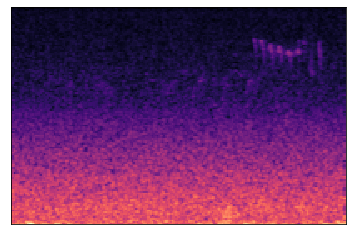

In [16]:
librosa.display.specshow(image);

These melspectrograms seem to be all single-channeled. Besides, probably due to the fact we have always taken the same number of samples (after resampling with a common `SR`), we always obtain an ndarray of shape `(128, 201)`.

In [17]:
list(range(0, 88, 5))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

## Statistics on `train_short_audio/`
I would like to know some statistics like

- How many `.ogg` files does each bird label have?
  - Linux's `tree` command might be able to answer to this question.
- How long are these `.ogg` files? Are some a lot longer than others?

In [18]:
!tree $PATH_DATASET/train_short_audio/* --filelimit 3

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/acafly [132 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/acowoo [190 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/aldfly [227 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/ameavo [44 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amecro [229 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amegfi [181 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amekes [82 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/amepip [98 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_aud

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/cangoo [265 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/canwar [126 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/carchi [154 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/carwre [464 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/casfin [123 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/caskin [169 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/caster1 [144 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/casvir [117 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/haiwoo [176 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/heptan [22 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/hergul [179 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/herthr [297 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/herwar [51 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/higmot1 [46 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/hofwoo1 [18 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/houfin [278 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_au

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rewbla [500 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/ribgul [63 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rinkin1 [124 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/roahaw [338 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/robgro [127 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rocpig [128 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/rotbec [68 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/royter1 [74 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_a

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/towsol [96 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/treswa [94 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/trogna1 [148 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/trokin [290 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/tromoc [131 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/tropar [173 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/tropew1 [78 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/tuftit [245 entries exceeds filelimit, not opening dir]
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_a

Well, if we are to use `tree`, we'd be better off writing a whole shell script. Let's try it Python way.

In [19]:
PATH_DATASET.stat()

os.stat_result(st_mode=16877, st_ino=41945604, st_dev=2052, st_nlink=5, st_uid=1000, st_gid=1000, st_size=4096, st_atime=1620201407, st_mtime=1617872843, st_ctime=1617872843)

In [20]:
PATH_DATASET.stat().st_size

4096

In [21]:
len(list(PATH_DATASET.iterdir()))

7

`st_size` is the size of the file, i.e. how many bytes.

In [22]:
!ls -ld $PATH_DATASET

drwxr-xr-x 5 phunc20 phunc20 4096 Apr  8 16:07 /home/phunc20/datasets/kaggle/birdclef-2021


In [23]:
D_label_nShort = dict()

In [24]:
for p in (PATH_DATASET / "train_short_audio").iterdir():
    n_oggs = len(set(p.iterdir()))
    print(f"{p.name:10s}{n_oggs: 5d}")
    D_label_index[p.name] = n_oggs

cubthr      500
grekis      357
cotfly1     141
carwre      464
norcar      500
wesblu       53
bknsti      137
linspa      174
creoro1     132
yebela1     145
grasal1     289
bkbwar      111
fiespa      137
scptyr1     165
willet1      94
banwre1     103
tuftit      245
easblu      113
amerob      481
rcatan1     168
rtlhum       88
rufhum       64
sander       75
buhvir      153
rehbar1      37
chispa      240
higmot1      46
monoro1      64
thbeup1     104
acowoo      190
bkcchi      272
yeteup1      52
sltred      193
houspa      500
cregua1      47
yetvir      107
mouwar      127
cocwoo1      82
ducfly      306
casfin      123
shicow       96
blbthr1     100
subfly      146
wrenti       74
oaktit      107
pirfly1     205
phivir       47
orcpar       88
lesvio1     167
chbchi       65
calqua      114
buggna      218
wegspa1      10
categr       98
brebla       52
squcuc1     205
dusfly      113
pinsis      150
stvhum2       8
thswar1     120
gbbgul       79
brratt1     265
putfru1 

In [25]:
def duration(path_ogg):
    audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")
    return len(audio) / SR

The following cell can display the number of seconds each `.ogg` file lasts, but it's **time-consuming**; we'd better combine it with other loops for reading all the short audio files.
> But the result show that the duration is not quite homogeneous: it could range from as low as 6 seconds to sth like 200 seconds.

In [26]:
for p_label in (PATH_DATASET / "train_short_audio").iterdir():
    print(f"{p_label.name}")
    for p_ogg in p_label.iterdir():
        print(f"\t{p_ogg.name:20s} {duration(p_ogg): 10.2f}")

cubthr
	XC255999.ogg              16.84
	XC263086.ogg              65.03
	XC537438.ogg              38.18
	XC296962.ogg              59.08
	XC255934.ogg             188.57
	XC612139.ogg             521.41
	XC617473.ogg              40.62
	XC170661.ogg              86.23
	XC617262.ogg             230.68
	XC256417.ogg             505.82
	XC512338.ogg              40.12
	XC298127.ogg              69.78
	XC511257.ogg              55.98
	XC450473.ogg               9.26
	XC617607.ogg              49.02
	XC256386.ogg             102.57
	XC256076.ogg             221.06
	XC450487.ogg             146.04
	XC616939.ogg             580.01
	XC256610.ogg             198.28
	XC512340.ogg             179.29
	XC305870.ogg             138.57
	XC256349.ogg             170.33
	XC256435.ogg             167.25
	XC512342.ogg              70.79
	XC361494.ogg             166.50
	XC263081.ogg              50.72
	XC450478.ogg              61.35
	XC617548.ogg              90.97
	XC297278.ogg             108.44
	XC

	XC617273.ogg             163.00
	XC450488.ogg             147.76
	XC255956.ogg              81.02
	XC612150.ogg              22.02
	XC616938.ogg              41.16
	XC256616.ogg              19.14
	XC612126.ogg              90.83
	XC305871.ogg              51.50
	XC450486.ogg              10.91
	XC256182.ogg             143.82
	XC450485.ogg              62.81
	XC168473.ogg              56.36
	XC256410.ogg             175.17
	XC573475.ogg              44.87
	XC554910.ogg              23.18
	XC610292.ogg              72.79
	XC256563.ogg             171.38


KeyboardInterrupt: 

## `train_soundscapes/`

In [27]:
df_train_soundscape = pd.read_csv(PATH_DATASET/"train_soundscape_labels.csv")
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [28]:
df_train_soundscape.notnull().all()

row_id      True
site        True
audio_id    True
seconds     True
birds       True
dtype: bool

There are a total of `20` `.ogg` files in `train_soundscapes/`: I would like to split these into train/val/test sets.

- `12` files for train
- `4` files for val
- `4` files for test

### Nota Bene
Just be careful: We decided to split the training data given by Kaggle into 3 parts -- train/val/test. So the word **`train`** in what follows may

- either means `train-train`
- or just `train`

Sorry for the confusion and the abuse, but unless I find time or I wouldn't correct it.

In [29]:
n_train = 12
n_val = 4     # Maybe I will put train and val together
n_test = 4

In [30]:
L_paths_train_soundscape = list((PATH_DATASET / "train_soundscapes").iterdir())
L_paths_train_soundscape

[PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26709_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/28933_SSW_20170408.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/57610_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26746_COR_20191004.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7843_SSW_20170325.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/44957_COR_20190923.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/14473_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/31928_COR_20191004.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/54955_SSW_20170617.ogg'),
 P

In [31]:
L_testSoundScapeIDs = [int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:]]
S_testSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:])
L_testSoundScapeIDs

[21767, 11254, 10534, 50878]

In [32]:
df_train_soundscape.columns

Index(['row_id', 'site', 'audio_id', 'seconds', 'birds'], dtype='object')

In [33]:
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [34]:
PATH_DATASET._str

'/home/phunc20/datasets/kaggle/birdclef-2021'

In [35]:
df_train_soundscape.dtypes

row_id      object
site        object
audio_id     int64
seconds      int64
birds       object
dtype: object

In [36]:
df_train_soundscape.audio_id

0        7019
1        7019
2        7019
3        7019
4        7019
        ...  
2395    54955
2396    54955
2397    54955
2398    54955
2399    54955
Name: audio_id, Length: 2400, dtype: int64

In [37]:
df_train_soundscape.audio_id.unique()

array([ 7019,  7954, 11254, 18003, 21767, 26746, 31928, 44957, 50878,
       57610,  2782,  7843, 10534, 14473, 20152, 26709, 28933, 42907,
       51010, 54955])

In [38]:
df_train_soundscape.audio_id.any() in L_testSoundScapeIDs

False

In [39]:
L_testSoundScapeIDs

[21767, 11254, 10534, 50878]

In [40]:
L_testSoundScapeIDs[0] in df_train_soundscape.audio_id

False

In [41]:
df_train_soundscape["is_test"] = [ (id_ in S_testSoundScapeIDs)
                                  for id_ in df_train_soundscape.audio_id]
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds,is_test
0,7019_COR_5,COR,7019,5,nocall,False
1,7019_COR_10,COR,7019,10,nocall,False
2,7019_COR_15,COR,7019,15,nocall,False
3,7019_COR_20,COR,7019,20,nocall,False
4,7019_COR_25,COR,7019,25,nocall,False


`mkdir` for places to store melspectrogram `.npy` files

In [42]:
trainSoundScapes = Path("./trainSoundScapes")
trainSoundScapes.exists()

False

In [43]:
trainSoundScapes.mkdir(exist_ok=True)
trainSoundScapes.exists()

True

In [44]:
testSoundScapes = Path("./testSoundScapes")
testSoundScapes.exists()

False

In [45]:
testSoundScapes.mkdir(exist_ok=True)
testSoundScapes.exists()

True

In [46]:
ls

01-data_exploration.ipynb  testSoundScapes/  trainSoundScapes/  trash.py


`NamedTuple` and `itertuples()` method from dataframe

In [47]:
list((PATH_DATASET / "train_soundscapes").glob("*7019_COR*.ogg"))

[PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg')]

In [48]:
next((PATH_DATASET / "train_soundscapes").glob("*7019_COR*.ogg"))

PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg')

In [49]:
class AudioToImage:
    def __init__(self,
                 sr=SR,
                 n_mels=128,
                 fmin=0,
                 fmax=None,
                 duration=DURATION,
                 step=None,
                 res_type="kaiser_fast",
                 resample=True):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr // 2

        self.duration = duration
        self.audio_length = self.duration*self.sr  # this is the #(samples) corresponding to DURATION=5 sec
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr,
                                                 n_mels=self.n_mels,
                                                 fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = standardize_uint8(melspec)
        return image

    def __call__(self, row, save=True, save_to=None, is_short_audio=False):
        #max_audio_duration = 10*self.duration
        #init_audio_length = max_audio_duration*row.sr
        #start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)

        if save and save_to is None:
            print("Nothing was done. If you want to save=True, please specify save_to=some_path")
            return
    
        #audio, orig_sr = soundfile.read(row.filepath, dtype="float32")

        #if self.resample and orig_sr != self.sr:
        #    audio = librosa.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        #audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
        #audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
        #images = [self.audio_to_image(audio) for audio in audios]
        #images = np.stack(images)
        if not is_short_audio:
            # Then audio from train_soundscapes/
            # an audio every 5 sec
            path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"*{row.audio_id}_{row.site}*.ogg"))
            audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
            if self.resample and orig_sr != self.sr:
                audio = librosa.resample(audio, orig_sr, self.sr, res_type=self.res_type)
            start_index = (row.seconds - self.duration) * self.sr
            audio = audio[start_index:start_index + self.audio_length]
            image = self.audio_to_image(audio)
          
        if save:
            #path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/f"{row.primary_label}/{row.filename}.npy"
            path = save_to / f"{row.row_id}.npy"
            path.parent.mkdir(exist_ok=True, parents=True)
            np.save(str(path), image)
        else:
            return  row.row_id, image


def get_audios_as_images(df, save_to=None):
    pool = joblib.Parallel(4)
    
    #converter = AudioToImage(step=int(DURATION*0.666*SR))
    #def __call__(self, row, save=True, save_to=None, is_short_audio=False):
    converter = AudioToImage()
    mapper = joblib.delayed(converter)
    #tasks = [mapper(row) for row in df.itertuples(False)]
    tasks = [mapper(row, save_to=save_to) for row in df.itertuples(False)]
    
    pool(tqdm(tasks))

### So Wrong
There are a few drawbacks in the previous two cells:
- It was wrong by saving all `.npy` files to `trainSoundScape` directory: Some should be saved to `testSoundScape` directory.
- It is not sufficient because the same `.ogg` file is opened and read several times.
  - Write a function or a class of your own and stop using kkiller's in this case.

### Objectives: Save `.npy` Files
Let's make our objectives clear.

01. We want to save each `train_soundscapes/` audio file, each 5-sec clip, to an `.npy` file.
  - The file reading and melspectrogram transform might be quite blocking, so **asynchronous** or **multi-process** (e.g. `concurrent.futures.ProcessPoolExecutor` or `joblib`) programming might be useful here.
02. We want to update `df_train_soundscape` to contain more information. What information?
  - Date: Can be separated.
  - Corresponding `.npy` path: Can be separated.
  - Longitude, latitude: Can be separated.
  
Since the two objectives above can be separated, and updating an extra dataframe while saving `.npy` for each `.ogg` file can become quite complicated, let's first get objective 1 done and start objective 2 after that.

### Objective 1: `.ogg` to `.npy`

#### `joblib` way

In [51]:
list(range(10))[0:-3]

[0, 1, 2, 3, 4, 5, 6]

In [52]:
list(range(10))[:-3]

[0, 1, 2, 3, 4, 5, 6]

In [53]:
S_trainSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[:-n_test])
S_trainSoundScapeIDs#, len(S_trainSoundScapeIDs)

{2782,
 7019,
 7843,
 7954,
 14473,
 18003,
 20152,
 26709,
 26746,
 28933,
 31928,
 42907,
 44957,
 51010,
 54955,
 57610}

In [54]:
next((PATH_DATASET / "train_soundscapes").glob(f"50878*.ogg"))

PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/50878_COR_20191004.ogg')

In [55]:
np.arange(10)[9:100]

array([9])

In [56]:
id_ = 1391
location = "SWC"
n_samples_5sec = 231
i = 6 * n_samples_5sec
f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"

'1391_SWC_35.npy'

In [85]:
def audio_to_mels(audio,
                  sr=SR,
                  n_mels=128,
                  fmin=0,
                  fmax=None):
    fmax = fmax or sr // 2
    mel_spec_computer = MelSpecComputer(sr=sr,
                                        n_mels=n_mels,
                                        fmin=fmin,
                                        fmax=fmax)
    mels = standardize_uint8(mel_spec_computer(audio))
    return mels

def every_5sec(id_,
               sr=SR,
               resample=True,
               res_type="kaiser_fast",
               single_process=True,
               save_to=Path("corbeille"),
               n_workers=2
                ):
    """
    - read the audio file of ID `id_`
    - cut the read audio into pieces of 5 seconds
    - convert each piece into `.npy` file and save
    """
    path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"{id_}*.ogg"))
    location = (path_ogg.name).split("_")[1]
    whole_audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    if resample and orig_sr != sr:
        whole_audio = librosa.resample(whole_audio, orig_sr, sr, res_type=res_type)
    n_samples = len(whole_audio)
    n_samples_5sec = sr * 5
    save_to.mkdir(exist_ok=True)

    def convert_and_save(i):
        audio_i = whole_audio[i:i + n_samples_5sec]
        mels_i = audio_to_mels(audio_i)
        path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
        np.save(str(path_i), mels_i)

    if single_process:
        for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec):
            #audio_i = whole_audio[i:i + n_samples_5sec]
            ## No need the next check because in range() we have subtracted the remainder.
            ## That is, len(audio_i) is guaranteed to be n_samples_5sec for all i.
            ##if len(audio_i) < n_samples_5sec:
            ##    pass
            #mels_i = audio_to_mels(audio_i)
            #path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
            #np.save(str(path_i), mels_i)
            convert_and_save(i)
    else:
        pool = joblib.Parallel(n_workers)
        mapping = joblib.delayed(convert_and_save)
        tasks = (mapping(i) for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec))
        pool(tasks)

def soundscapes_to_npy(is_test=False, n_processes=4):
    pool = joblib.Parallel(n_processes)
    mapping = joblib.delayed(every_5sec)
    if is_test:
        tasks = list(mapping(id_, save_to=testSoundScapes) for id_ in S_testSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=testSoundScapes)
        #             for id_ in S_testSoundScapeIDs)
    else:
        tasks = list(mapping(id_, save_to=trainSoundScapes) for id_ in S_trainSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=trainSoundScapes)
        #             for id_ in S_trainSoundScapeIDs)
    pool(tqdm(tasks))

### Nota Bene
- `tasks` (i.e. input to `joblib.Parallel`) can be either a generator or a list, but since I do not know a priori the length of a generator, when combined with the usage of `tqdm`, the progress bar will lack the capability to show progress percentage, compared to using a list.

In [86]:
%%time
soundscapes_to_npy()

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 265 ms, sys: 9.31 ms, total: 275 ms
Wall time: 26.7 s


In [76]:
soundscapes_to_npy(is_test=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [83]:
S_testSoundScapeIDs

{10534, 11254, 21767, 50878}

In [78]:
!ls $trainSoundScapes | wc -l

1920


In [79]:
!ls $testSoundScapes | wc -l

480


In [80]:
16 * (600 // 5)

1920

In [81]:
4 * (600 // 5)

480

Let's at least verify that the saved images exhibit difference.<br>
Try execute the next cell several times to see randomly the melspectrograms.

rand_npy = 14473_SSW_230.npy


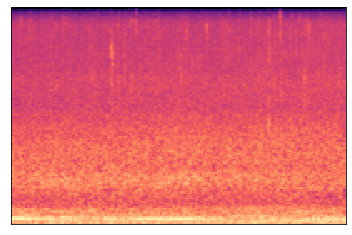

In [188]:
rand_npy = random.choice(list(trainSoundScapes.iterdir()))
rand_image = np.load(rand_npy)
print(f"rand_npy = {rand_npy.name}")
librosa.display.specshow(rand_image);

### Objective 2: Construct `df_train_soundscape`

Recall that
> - We want to update `df_train_soundscape` to contain more information. What information?
>   - Date: Can be separated.
>   - Corresponding `.npy` path: Can be separated.
>   - Longitude, latitude: Can be separated.

In [189]:
df_train_soundscape

,row_id,site,audio_id,seconds,birds,is_test
0,7019_COR_5,COR,7019,5,nocall,False
1,7019_COR_10,COR,7019,10,nocall,False
2,7019_COR_15,COR,7019,15,nocall,False
3,7019_COR_20,COR,7019,20,nocall,False
4,7019_COR_25,COR,7019,25,nocall,False
...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,False
2396,54955_SSW_585,SSW,54955,585,grycat,False
2397,54955_SSW_590,SSW,54955,590,grycat,False
2398,54955_SSW_595,SSW,54955,595,nocall,False


Construct a dictionary for

- key: recording location, e.g. `COR`, `SSW`, etc.
- value: possibly `NamedTuple(longitude, latitude)`

Fill in date info to `train_soundscape_labels.csv` from `train_soundscapes/`